This is a _working_ notebook. See the `ccdControlIntro` notebook for a more narrative how-to. In this notebook, most cells have acquisition, processing, and plotting.

In [1]:
# All system imports
import logging
import time
import clocks
import fitsio

import numpy as np
import scipy
import scipy.optimize as opt

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
import power.PCM as PCM
reload(PCM)

pcm = PCM.PCM(host='10.1.1.14')
pcm.logger.setLevel(logging.DEBUG)

In [3]:
def gobbleFeeOutput():
    while True:
        ret = fee.readResponse()
        print "got: ", ret
        if ret == '':
            break

def feeUp0():
    print "feeUp0"
    pcm.powerOn('fee')
    time.sleep(4)

def feeUp1():
    print "feeUp1"
    logLevel = 20
    fee = feeMod.FeeControl(logLevel=logLevel)
    fee.powerUp(preset='wipe')

def feeUp():
    feeUp0()
    feeUp1()
    
def feeBump():
    print "feeBump"

    pcm.powerCmd('fee', False)
    time.sleep(3)
    feeUp0()

def fullBump():
    feeUp1()
    time.sleep(1.5)
    fee.powerDown()
    time.sleep(1)
    pcm.powerOff('fee')
    
def V1():
    for m in ('erase', 'wipe', 'expose', 'read', 'erase'):
        fee.setMode(m)
        time.sleep(1)
        
def V0():
    feeUp0()
    feeUp1()
    time.sleep(1)
    fee.setMode('erase')
    time.sleep(1)
    fee.setMode('read')
    ccd.readImage(nrows=2, ncols=100, 
                  clockFunc=pfsClocks, doSave=False)
    fee.setMode('wipe')
    time.sleep(1)
    fee.powerDown()
    time.sleep(1)
    pcm.powerOff('fee')
    
    
#feeUp1()
#time.sleep(2)
#feeBump()
#print fee.doGet('voltage','54VP')


In [4]:
#V1()

In [5]:
pcm.powerOn('fee')

DEBUG:root:sending '~14\r\n'
DEBUG:root:received 'Success'


Success


In [6]:
import testing.ampswitch as ampSwitch
reload(ampSwitch)

useAmpSwitch = False
if useAmpSwitch:
    pcm.powerCmd('ampSwitch', useAmpSwitch)

    try:
        switch.close()
    except:
        pass

    switch = ampSwitch.AmpSwitch(host='10.1.1.21')
    switch.readCoils()

In [7]:
# FEE connection and initialization.
# Initialize everything to some sane state.
import fee.feeControl as feeMod
reload(feeMod)

doLoad = False # '/home/pfs/feeMain-2015-07-28_04.hex'
doCalib = False

defaultState = 'erase' # 'BT1'
logLevel = 20
fee = feeMod.FeeControl(port='/dev/ttyS1', logLevel=logLevel)
if doLoad:
    pcm.powerCmd('fee', turnOn=False)
    time.sleep(0.5)

    pcm.powerCmd('fee', turnOn=True)
    fee.sendImage(doLoad)

    time.sleep(2)
    pcm.powerCmd('fee', turnOn=False)
    time.sleep(1)
    pcm.powerCmd('fee', turnOn=True)
    time.sleep(4)
    fee = feeMod.FeeControl(logLevel=logLevel)
    fee.powerUp(defaultState)
else:
    fee.powerUp(defaultState)
    
if doCalib:
    fee.raw('lp,read')
    fee.raw('cal,CDS')
    fee.raw('cal,bias')
    for channel in 0,1:
        fee.doSet('bias', 'P_off', -1.0, channel=channel) 
        fee.doSet('bias', 'S_off', -1.0, channel=channel)
        fee.doSet('bias', 'S_on', 3.0, channel=channel)
    fee.raw('sp,BT1')

    time.sleep(1)
    pcm.powerCmd('fee', turnOn=False)
    time.sleep(1)
    pcm.powerCmd('fee', turnOn=True)
    time.sleep(4)
    fee = feeMod.FeeControl(logLevel=logLevel)
    fee.powerUp()
    time.sleep(1)
    


SUCCESS
SUCCESS
SUCCESS


In [8]:
#fee.zeroOffsets()
defOffsets = np.array([10]*8)
fee.setOffsets(np.arange(8), -defOffsets, leg='p')
fee.setOffsets(np.arange(8), defOffsets, leg='n')

In [10]:
fee.sendCommandStr('lp,read')
t0 = time.time()
stat = fee.getAllStatus()
t1 = time.time()
fee.sendCommandStr('lp,erase')

print "that took %0.3f s" % (t1-t0)

fee.printStatus()

feeCards = fee.statusAsCards()

that took 11.845 s
bias.ch0.P_on :  -5.03
bias.ch0.P_off :  3.01
bias.ch0.DG_on :  -5.03
bias.ch0.DG_off :  4.99
bias.ch0.S_on :  -6.04
bias.ch0.S_off :  3.01
bias.ch0.SW_on :  -6.04
bias.ch0.SW_off :  5.03
bias.ch0.RG_on :  -7.57
bias.ch0.RG_off :  2.01
bias.ch0.OG :  -4.54
bias.ch0.RD :  -1.69
bias.ch0.OD :  -2.87
bias.ch0.BB :  46.99
bias.ch1.P_on :  -5.04
bias.ch1.P_off :  3.01
bias.ch1.DG_on :  -5.04
bias.ch1.DG_off :  4.99
bias.ch1.S_on :  -6.04
bias.ch1.S_off :  3.01
bias.ch1.SW_on :  -6.04
bias.ch1.SW_off :  5.03
bias.ch1.RG_on :  -7.58
bias.ch1.RG_off :  2.01
bias.ch1.OG :  -4.54
bias.ch1.RD :  -8.52
bias.ch1.OD :  -19.64
bias.ch1.BB :  28.73
voltage.3V3M :  3.28
voltage.3V3 :  3.26
voltage.5VP :  4.95
voltage.5VN :  -4.93
voltage.5VPpa :  4.96
voltage.5VNpa :  -4.85
voltage.12VP :  11.56
voltage.12VN :  -11.65
voltage.24VN :  -22.99
voltage.54VP :  49.1
offset.ch0.0p :  -9.97
offset.ch0.1p :  -9.99
offset.ch0.2p :  -9.96
offset.ch0.3p :  -9.94
offset.ch0.0n :  10.02
offset.ch

In [11]:
cmds = 'gb', 'rb'
chans = 'ch0', 'ch1'

fee.logger.setLevel(20)
for mode in 'erase', 'expose', 'read', 'wipe':
    fee.setMode(mode)

    print "======== %s" % mode
    
    for k in fee.allKeys('bias'):
        print "%-8s " % k,
        for chan in chans:
            for cmd in cmds:
                v = fee.sendCommandStr('%s,%s,%s' % (cmd, k, chan))
                print "%6s " % (v),
            print "    ",
        print
    
fee.setMode('erase')


======== erase
P_on        6.00    5.99         6.00    5.99      
P_off       6.00    5.99         6.00    5.99      
DG_on       6.00    5.99         6.00    5.99      
DG_off      6.00    5.99         6.00    5.99      
S_on        6.00    5.99         6.00    5.99      
S_off       6.00    5.99         6.00    5.99      
SW_on       6.00    5.99         6.00    5.99      
SW_off      6.00    6.04         6.00    6.04      
RG_on       6.00    6.00         6.00    6.00      
RG_off      6.00    6.00         6.00    6.00      
OG          6.00    6.00         6.00    6.00      
RD        -12.00   -1.69       -12.00   -8.52      
OD         -5.00  -11.05        -5.00   -4.78      
BB          0.20   46.95         0.20    0.00      
======== expose
P_on       -5.00   -5.03        -5.00   -5.04      
P_off       3.00    3.01         3.00    3.01      
DG_on      -5.00   -5.03        -5.00   -5.04      
DG_off      5.00    4.99         5.00    4.99      
S_on       -6.00   -6.04        -

In [12]:
if False:
    fee.device.setTimeout(2.0)
    print fee.saveModesToFee()
    fee.device.setTimeout(0.5)

In [13]:
if False:
    fee.unlockConfig()
    fee.setSerial('ADC', 3063061)
    fee.setSerial('PA0', 186)
    fee.lockConfig()

In [14]:
# FPGA connection and initialization.
# All the reloads are to make sure that new code gets picked up
import fpga as fpgaMod
import fpga.ccdFuncs as ccdFuncs
import fpga.nbFuncs as nbFuncs

reload(fpgaMod)
reload(fpgaMod.ccd)
reload(fpgaMod)

ccd = fpgaMod.CCD(adc18bit=1)  # adc18bit=2 reads the low bits.
ccd.pciReset()
print "FPGA version: 0x%08x" % (ccd.peekWord(0))

FPGA version: 0xbeefa070


In [15]:
# Load the clock tables. pfsClocks is used for each readout.
import clocks_001
import clocks_002
import clocks
reload(clocks_001)
reload(clocks_002)
reload(clocks)

pfsClocks = clocks_002.readClocks
pre, pix, post = pfsClocks()


In [20]:
reload(nbFuncs)

doGainCurve = False
if doGainCurve:
    fee.zeroOffsets()
    stepSize = 19.9*2
    statCols = slice(5,None)
    amps = np.arange(8)
    noffsets, nlevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=stepSize, leg='n', 
                                          statCols=statCols, doUnwrap=65000)
    poffsets, plevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=-stepSize, leg='p', 
                                          statCols=statCols, doUnwrap=65000)
    
    print
    nfits = nbFuncs.plotGains(noffsets, nlevels, amps=amps)
    print
    pfits = nbFuncs.plotGains(poffsets, plevels, amps=amps)

In [22]:
%pdb off
reload(ccdFuncs)
reload(nbFuncs)

allAmps = np.arange(8)
badAmps = []

dummyCcd = False
if not dummyCcd:
    goodAmps = np.arange(8)

    startStep = 5
    levels = 1000
else:
    goodAmps = np.arange(4) + 4
    
    startStep = 10
    levels = np.zeros(8)
    levels[4:] = [10000,25000,20000,15000]

ncols=300

doTune = False
if doTune:
    offs, devs, gains = nbFuncs.tuneLevels(ccd, fee, levels=levels, adjOffset=5, 
                                           amps=goodAmps,
                                           statCols=slice(2,None), 
                                           maxLoops=10, nrows=200, 
                                           startStep=startStep, 
                                           startOffset=startStep,
                                           sigTol=4, 
                                           clockFunc=pfsClocks, 
                                           legs='np', # useGains=nfits[:,0], 
                                           doZero=True, doUnwrap=65000)

    defOffsets = offs


Automatic pdb calling has been turned OFF


0099 27183.0 30005.5 33486.2 42274.6 26315.0 29794.9 33228.3 42826.5 5.27 5.17 4.00 4.13 2.35 2.03 1.57 1.08 OK
0299 27168.2 29989.3 33473.6 42274.1 26301.0 29780.1 33219.9 42825.9 5.14 5.12 3.93 4.14 2.36 1.98 1.51 0.98 OK
means: [27168.113 29989.629 33473.822 42273.926 26300.931 29780.195 33219.876 42825.865]
devs:  [5.648 5.502 4.608 4.117 3.244 2.657 2.002 1.090]
peak:  26301.0 26294 28179 1878.0 6260.0 0.000159744408946
file: /data/pfs/2015-08-12/PFSA-00001304.fits


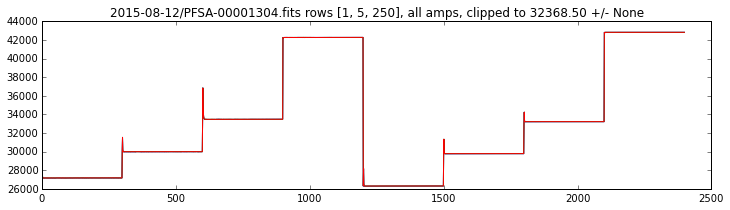

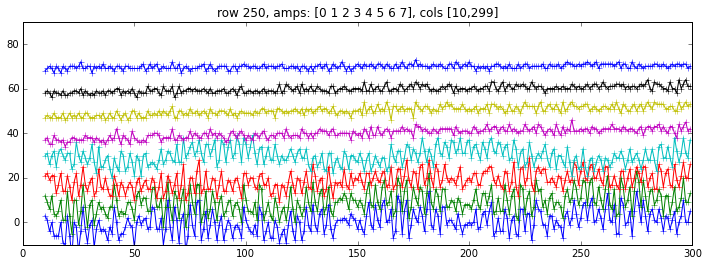

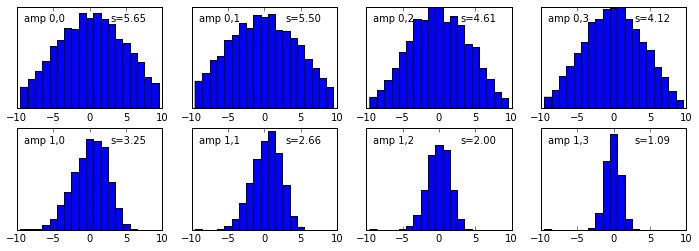

/home/pfs/hostdevel/fullAnaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


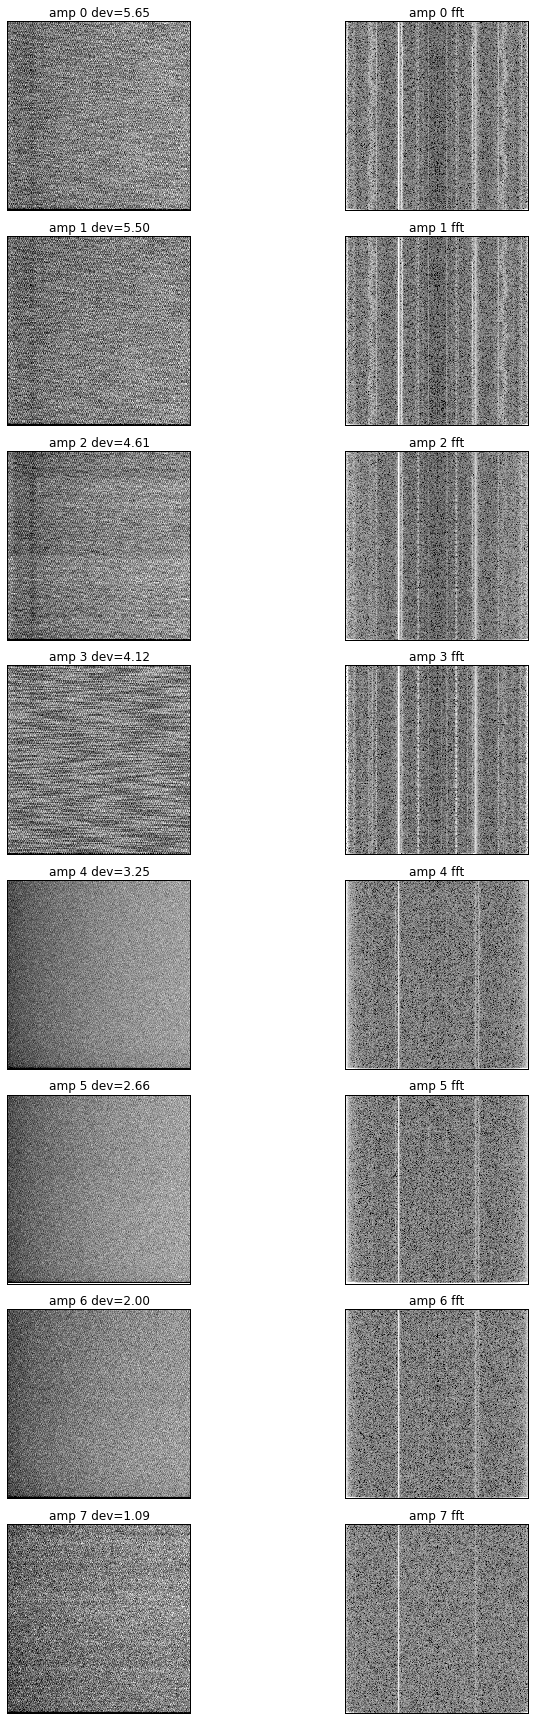

In [16]:
reload(ccdFuncs)
reload(nbFuncs)

fee.setMode('erase')

# fee.sendCommandStr('sf,slow')

goodAmps = np.arange(8) #[3,4,5,6, 7] # np.arange(8)
badAmps = []

nrows = 300                # How many rows to read out.
ncols = 300
selectRows = slice(0,500)
selectCols = None # slice(5,5)
pcols = np.arange(10,ncols)    # Which cols to plot
statCols = np.arange(10,ncols) # Which cols to use for stats
prow = (selectRows.stop+1)/2
prows = [1, 5, prow]       # which rows to plot
fftAmps = []

figWidth = 12

argDict = dict(everyNRows=300, ampList=goodAmps, cols=statCols, ccd=ccd)

siggenAmp = None
if siggenAmp is None:
    try:
        switch.setCoils(off=range(16))
    except:
        pass
else:
    switch.chooseCoil(siggenAmp)

comment = 'pure test'
flushRead = True
doFile = None # '/data/pfs/2015-06-02/PFSA-00000954.fits'
doSave = True
if doFile:
    im = fitsio.read(doFile)
else:
    fee.setMode('read')
    time.sleep(1)
    if flushRead:
        im, files = ccd.readImage(nrows=100, ncols=ncols, 
                                  rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                                  clockFunc=pfsClocks, doSave=False)
    im, files = ccd.readImage(nrows=nrows, ncols=ncols, 
                              rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                              clockFunc=pfsClocks, doSave=doSave,
                              comment=comment, addCards=feeCards)
    fee.setMode('erase')

if selectRows is not None:
    im = im[selectRows]
if selectCols is not None:
    im = im[:,selectCols]
    
im = im.astype('i4')
hi_w = np.where(im > 65500)
im[hi_w] -= 65535

if siggenAmp is None:
    amp4Mask = ccd.ampidx(4, im)
else:
    amp4Mask = ccd.ampidx(siggenAmp, im)

#amp6Mask = ccd.ampidx(6, im)
#im[:, amp6Mask] -= im[:, amp6Mask].mean()
#im[:, amp6Mask] += im[:, ccd.ampidx(4, im)].mean()

means,devs = nbFuncs.ampStats(im, ccd=ccd, cols=statCols)
print "means:", nbFuncs.fmtArr(means, format="%0.3f")
print "devs: ", nbFuncs.fmtArr(devs, format="%0.3f")
med4 = np.median(im[prow, amp4Mask])
max4 = np.max(im[prow, amp4Mask])
min4 = np.min(im[prow, amp4Mask])

inject = 0.3
print "peak: ", med4, min4, max4, max4-med4, (max4-med4)/inject, inject/(max4-med4)

# print "shape: %s dtype: %s" % (str(im.shape), im.dtype)
    
if len(files) > 0:
    path = files[0]
    imName = '/'.join(path.split('/')[-2:])
    print "file: %s" % (path)

#focusAmp = 0             # Which amp to focus on
#focusMask = ccd.ampidx(focusAmp, im)[pcols]

# plot one or more rows across the entire image
nbFuncs.plotRows(im, prows, imName=imName, figWidth=figWidth, pixRange=200 if siggenAmp is not None else None)

# plot one row for each the "good" amps
peaks = None # np.arange(1, ncols, 50)
if siggenAmp is not None:
    channel = siggenAmp/4
    amps0 = [siggenAmp]
    amps1 = goodAmps[np.where((goodAmps/4 == channel) & (goodAmps != siggenAmp))]
    amps2 = goodAmps[np.where(goodAmps/4 != channel)]

    nbFuncs.plotAmps(im, amps=amps0, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps1, row=prow, cols=pcols, 
                 plotOffset=100, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps2, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth)
else:
    nbFuncs.plotAmps(im, amps=goodAmps, row=prow, cols=pcols, 
                     plotOffset=10, fig=None, figWidth=figWidth, 
                     peaks=peaks, clipPeaks=True)

# f.axes[0].set_ylim(-50, 150)

# plot any bad amps individually
for a in badAmps:
    nbFuncs.plotAmps(im, amps=[a], row=prow, cols=pcols, figWidth=figWidth)

# show a grid of histograms.
hists = nbFuncs.ampHistGrid(im, ccd, cols=pcols, histRange=20, figWidth=figWidth)

# show a grid of raw amp images.
nbFuncs.rawAmpGrid(im, ccd, cols=pcols, figWidth=figWidth, showFfts=True)

fftAmps = [] # np.arange(8) # [1,2,5] # [5,6]
if len(fftAmps) > 0:    
    
    fftFig = plt.figure(figsize=(figWidth, figWidth/4))
    for a in fftAmps:
        fftFig = plt.figure(figsize=(figWidth, figWidth/4))
        fftMask = ccd.ampidx(a, im)[pcols]
        ampSeg = im[prow,fftMask]
        freqs, fft, peak_ii = ccdFuncs.plotTopPeriods(ampSeg, topN=3)


#fig.colorbar(pp)
#plt.tight_layout()